In [2]:
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt #to plot graphs
import squarify #for square chart

data = pd.read_excel("Online Retail.xlsx")

In [44]:
#Removing irrelevant data
data = data[(data['Quantity']>0)]
data=data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]

#Total price is number of quantity * per unit price
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
#Finding most recent and oldest order date
data['InvoiceDate'].min(),data['InvoiceDate'].max()
#PRESENT = dt.datetime(2020,12,31)
PRESENT = dt.datetime(2011,12,10)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [45]:
#RecentTransaction(Recency) = current date - Last transaction date
#NumOfTransactions(Frequency) = Total No. of Invoice per customer
#MoneySpent(Monetary) = Sum of Money spent for all transactions by single customer
rfm= data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})
rfm.columns=['RecentTransaction','NumOfTransactions','MoneySpent']
rfm['RecentTransaction'] = rfm['RecentTransaction'].astype(int)
rfm.head()

,RecentTransaction,NumOfTransactions,MoneySpent
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


In [46]:
#Lesser the value of RecentTransaction, Better Recency
rfm['Recency'] = pd.qcut(rfm['RecentTransaction'], 4, ['1','2','3','4'])
#Greater the value of NumOfTransactions, Better Frequency
rfm['Frequency'] = pd.qcut(rfm['NumOfTransactions'], 4, ['4','3','2','1'])
#Greater the value of MoneySpent, Better Monetary
rfm['Monetary'] = pd.qcut(rfm['MoneySpent'], 4, ['4','3','2','1'])
rfm.head()

,RecentTransaction,NumOfTransactions,MoneySpent,Recency,Frequency,Monetary
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12347.0,2,182,4310.00,1,1,1
12348.0,75,31,1797.24,3,3,1
12349.0,18,73,1757.55,2,2,1
12350.0,310,17,334.40,4,4,3


In [47]:
rfm['RFM_Score'] = rfm.Recency.astype(str)+ rfm.Frequency.astype(str) + rfm.Monetary.astype(str)
rfm['RFM_Sum'] = rfm.Recency.astype(int)+ rfm.Frequency.astype(int) + rfm.Monetary.astype(int)
rfm.head()

,RecentTransaction,NumOfTransactions,MoneySpent,Recency,Frequency,Monetary,RFM_Score,RFM_Sum
CustomerID,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9
12347.0,2,182,4310.00,1,1,1,111,3
12348.0,75,31,1797.24,3,3,1,331,7
12349.0,18,73,1757.55,2,2,1,221,5
12350.0,310,17,334.40,4,4,3,443,11


In [48]:
#Bifuracting customers into categories based on their RFM_Sum
def RFM_Category(df):
    if df['RFM_Sum'] < 5:
        return 'Champions'
    elif ((df['RFM_Sum'] >= 5) and (df['RFM_Sum'] < 6)):
        return 'Loyal'
    elif ((df['RFM_Sum'] >= 6) and (df['RFM_Sum'] < 7)):
        return 'Potential'
    elif ((df['RFM_Sum'] >= 7) and (df['RFM_Sum'] < 8)):
        return 'Promising'
    elif ((df['RFM_Sum'] >= 8) and (df['RFM_Sum'] < 9)):
        return 'Needs Attention'
    elif ((df['RFM_Sum'] >= 9) and (df['RFM_Sum'] < 11)):
        return 'About to Sleep'
    else:
        return 'Lost'

rfm['RFM_Category'] = rfm.apply(RFM_Category, axis=1)
rfm.head()

,RecentTransaction,NumOfTransactions,MoneySpent,Recency,Frequency,Monetary,RFM_Score,RFM_Sum,RFM_Category
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,About to Sleep
12347.0,2,182,4310.00,1,1,1,111,3,Champions
12348.0,75,31,1797.24,3,3,1,331,7,Promising
12349.0,18,73,1757.55,2,2,1,221,5,Loyal
12350.0,310,17,334.40,4,4,3,443,11,Lost


In [59]:
# Calculating mean for each RFM_Category, and returning total count(Using aggregate function)
RFM_Category_agg = rfm.groupby('RFM_Category').agg({'RecentTransaction': 'mean',
                                                'NumOfTransactions': 'mean',
                                                'MoneySpent': ['mean', 'count']}).round(1)
print(RFM_Category_agg)

                RecentTransaction NumOfTransactions MoneySpent      
                             mean              mean       mean count
RFM_Category                                                        
About to Sleep              125.9              24.5      583.3   982
Champions                    13.1             288.0     6894.0   835
Lost                        217.3              11.0      199.2   770
Loyal                        31.6             112.7     2058.3   428
Needs Attention              79.3              38.7      760.4   452
Potential                    45.6              80.1     1810.7   413
Promising                    63.7              57.0      994.1   459


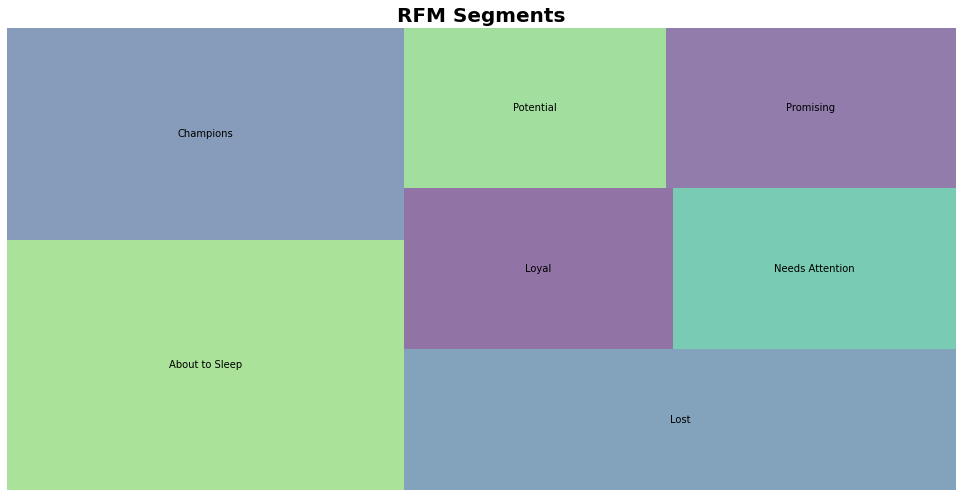

In [69]:
#To Visualize the data based on count
RFM_Category_agg.columns = ['RecentTransactionMean','NumOfTransactionsMean','MoneySpentMean', 'Count']

#Creating square plot using squarify and matplot
chart = plt.gcf()
ax = chart.add_subplot()
chart.set_size_inches(17, 8.5)
squarify.plot(sizes=RFM_Category_agg['Count'], 
              label=['About to Sleep',
                     'Champions',
                     'Lost',
                     'Loyal',
                     'Needs Attention',
                     'Potential',
                     'Promising'], alpha=.6 )
plt.title("RFM Segments",fontweight="bold",fontsize=20)
plt.axis('off')
plt.show()